In [2]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

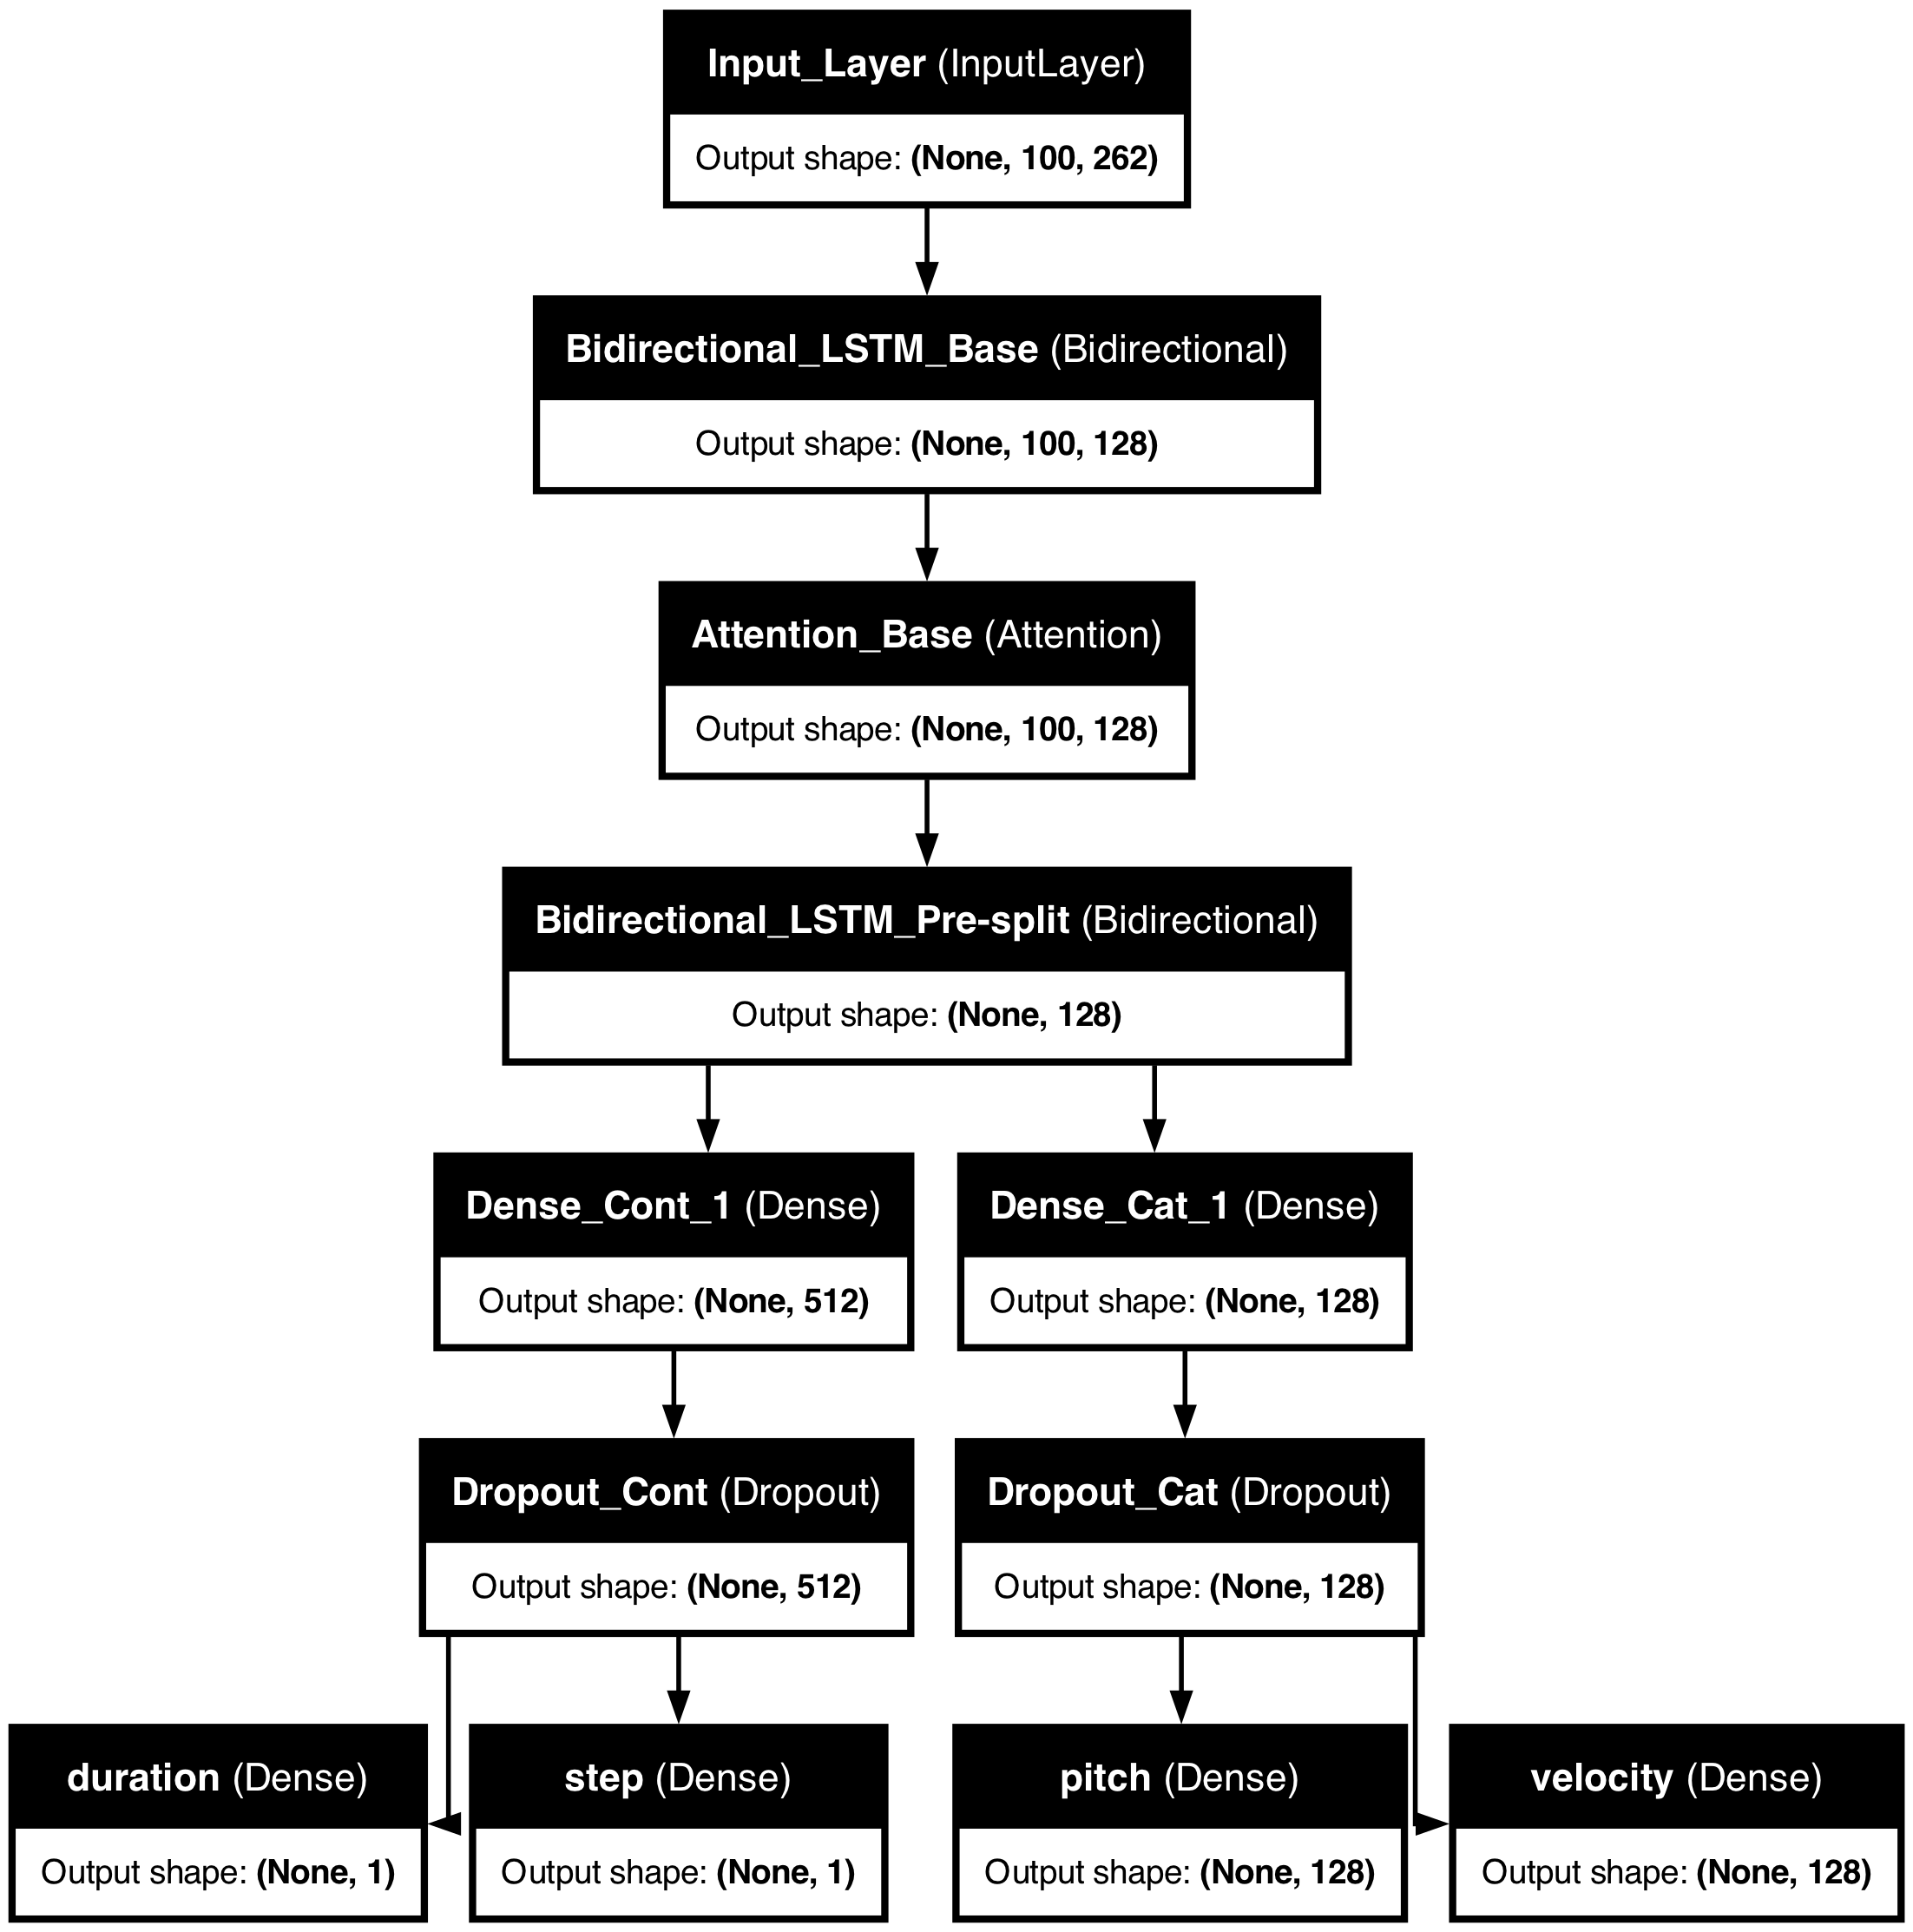

In [11]:
def create_actual_model(input_shape, learning_rate):
    inputs = tf.keras.Input(shape=input_shape, name='Input_Layer')

    # Base LSTM layers with attention
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), name='Bidirectional_LSTM_Base')(inputs)
    x = tf.keras.layers.Attention(name='Attention_Base')([x, x])

    # Final LSTM layer before branching
    final_lstm_layer = tf.keras.layers.LSTM(64, return_sequences=False, name='LSTM_Final')
    x = tf.keras.layers.Bidirectional(final_lstm_layer, name='Bidirectional_LSTM_Pre-split')(x)

    # Branch for categorical outputs
    x_cat = tf.keras.layers.Dense(128, activation='relu', name='Dense_Cat_1')(x)
    x_cat = tf.keras.layers.Dropout(0.3, name='Dropout_Cat')(x_cat)
    pitch = tf.keras.layers.Dense(128, activation='softmax', name='pitch')(x_cat)
    velocity = tf.keras.layers.Dense(128, activation='softmax', name='velocity')(x_cat)

    # Branch for continuous outputs
    x_cont = tf.keras.layers.Dense(512, activation='relu', name='Dense_Cont_1')(x)
    x_cont = tf.keras.layers.Dropout(0.3, name='Dropout_Cont')(x_cont)
    step = tf.keras.layers.Dense(1, activation=None, name='step')(x_cont)  # Linear activation for continuous
    duration = tf.keras.layers.Dense(1, activation=None, name='duration')(x_cont)  # Linear activation for continuous

    # Model setup
    model = tf.keras.Model(inputs=inputs, outputs={'pitch': pitch, 'velocity': velocity, 'step': step, 'duration': duration})
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss={
            'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            'velocity': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            'step': 'mse',   # Mean Squared Error for regression
            'duration': 'mse'
        }
    )

    return model

actual_model = create_actual_model((100, 262), 0.005)
plot_model(actual_model, to_file='actual.png', show_shapes=True, show_layer_names=True)



In [4]:
def create_proposed_model(shape, lr=0.005):
    inputs = tf.keras.Input(shape=shape, name='Input_Layer')

    # shape of inputs is like so (100, 262), timesteps, features. Extract the last four features
    emotional_features = inputs[:, :, -4:]
    musical_features = inputs[:, :, :-4]

    musical = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), name='LSTM_Musical')(musical_features)
    musical = tf.keras.layers.Attention(name='Attention_Musical')([musical, musical])

    final_musical_lstm_layer = tf.keras.layers.LSTM(64, return_sequences=False, name='LSTM_Final_Musical')
    musical = tf.keras.layers.Bidirectional(final_musical_lstm_layer)(musical)


    # same size emotional, so these four inputs get a low of attention
    emotional = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), name='LSTM_Emotional')(emotional_features)
    emotional = tf.keras.layers.Attention(name='Attention_Emotional')([emotional, emotional])

    final_emotional_lstm_layer = tf.keras.layers.LSTM(64, return_sequences=False, name='LSTM_Final_Emotional')
    emotional = tf.keras.layers.Bidirectional(final_emotional_lstm_layer)(emotional)

   # Define an additional input for halfway through the architecture
    halfway_input = tf.keras.Input(shape=(100, 4), name='Emotional_Input')
    # Select only the last timestep's features
    halfway_features = halfway_input[:, -1, :]  # This now becomes a 2D tensor with shape (None, 4)

    # Merge the two LSTM outputs and the halfway input into one layer
    x = tf.keras.layers.concatenate([musical, emotional, halfway_features], name='Concatenated')

    # create a dense layer, plug in x, and emotinal_features # PLUG IN EMOTIONAL FEATURES
    x = tf.keras.layers.Dense(128, activation='relu', name='Dense_Cat_1')(x)

    # branch into x_cat
    x_cat = tf.keras.layers.Dropout(0.3, name='Dropout_Cat')(x)
    pitch = tf.keras.layers.Dense(128, activation='softmax', name='pitch')(x_cat)
    velocity = tf.keras.layers.Dense(128, activation='softmax', name='velocity')(x_cat)

    # branch into x_cont
    x_cont = tf.keras.layers.Dense(512, activation='relu', name='Dense_Cont_1')(x)
    x_cont = tf.keras.layers.Dropout(0.3, name='Dropout_Cont')(x_cont)
    step = tf.keras.layers.Dense(1, activation=None, name='step')(x_cont)  # Linear activation for continuous
    duration = tf.keras.layers.Dense(1, activation=None, name='duration')(x_cont)  # Linear activation for continuous

    model = tf.keras.Model(inputs=inputs, outputs={'pitch': pitch, 'velocity': velocity, 'step': step, 'duration': duration})
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss={
            'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            'velocity': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            'step': 'mse',   # Mean Squared Error for regression
            'duration': 'mse'
        }
    )

    return model

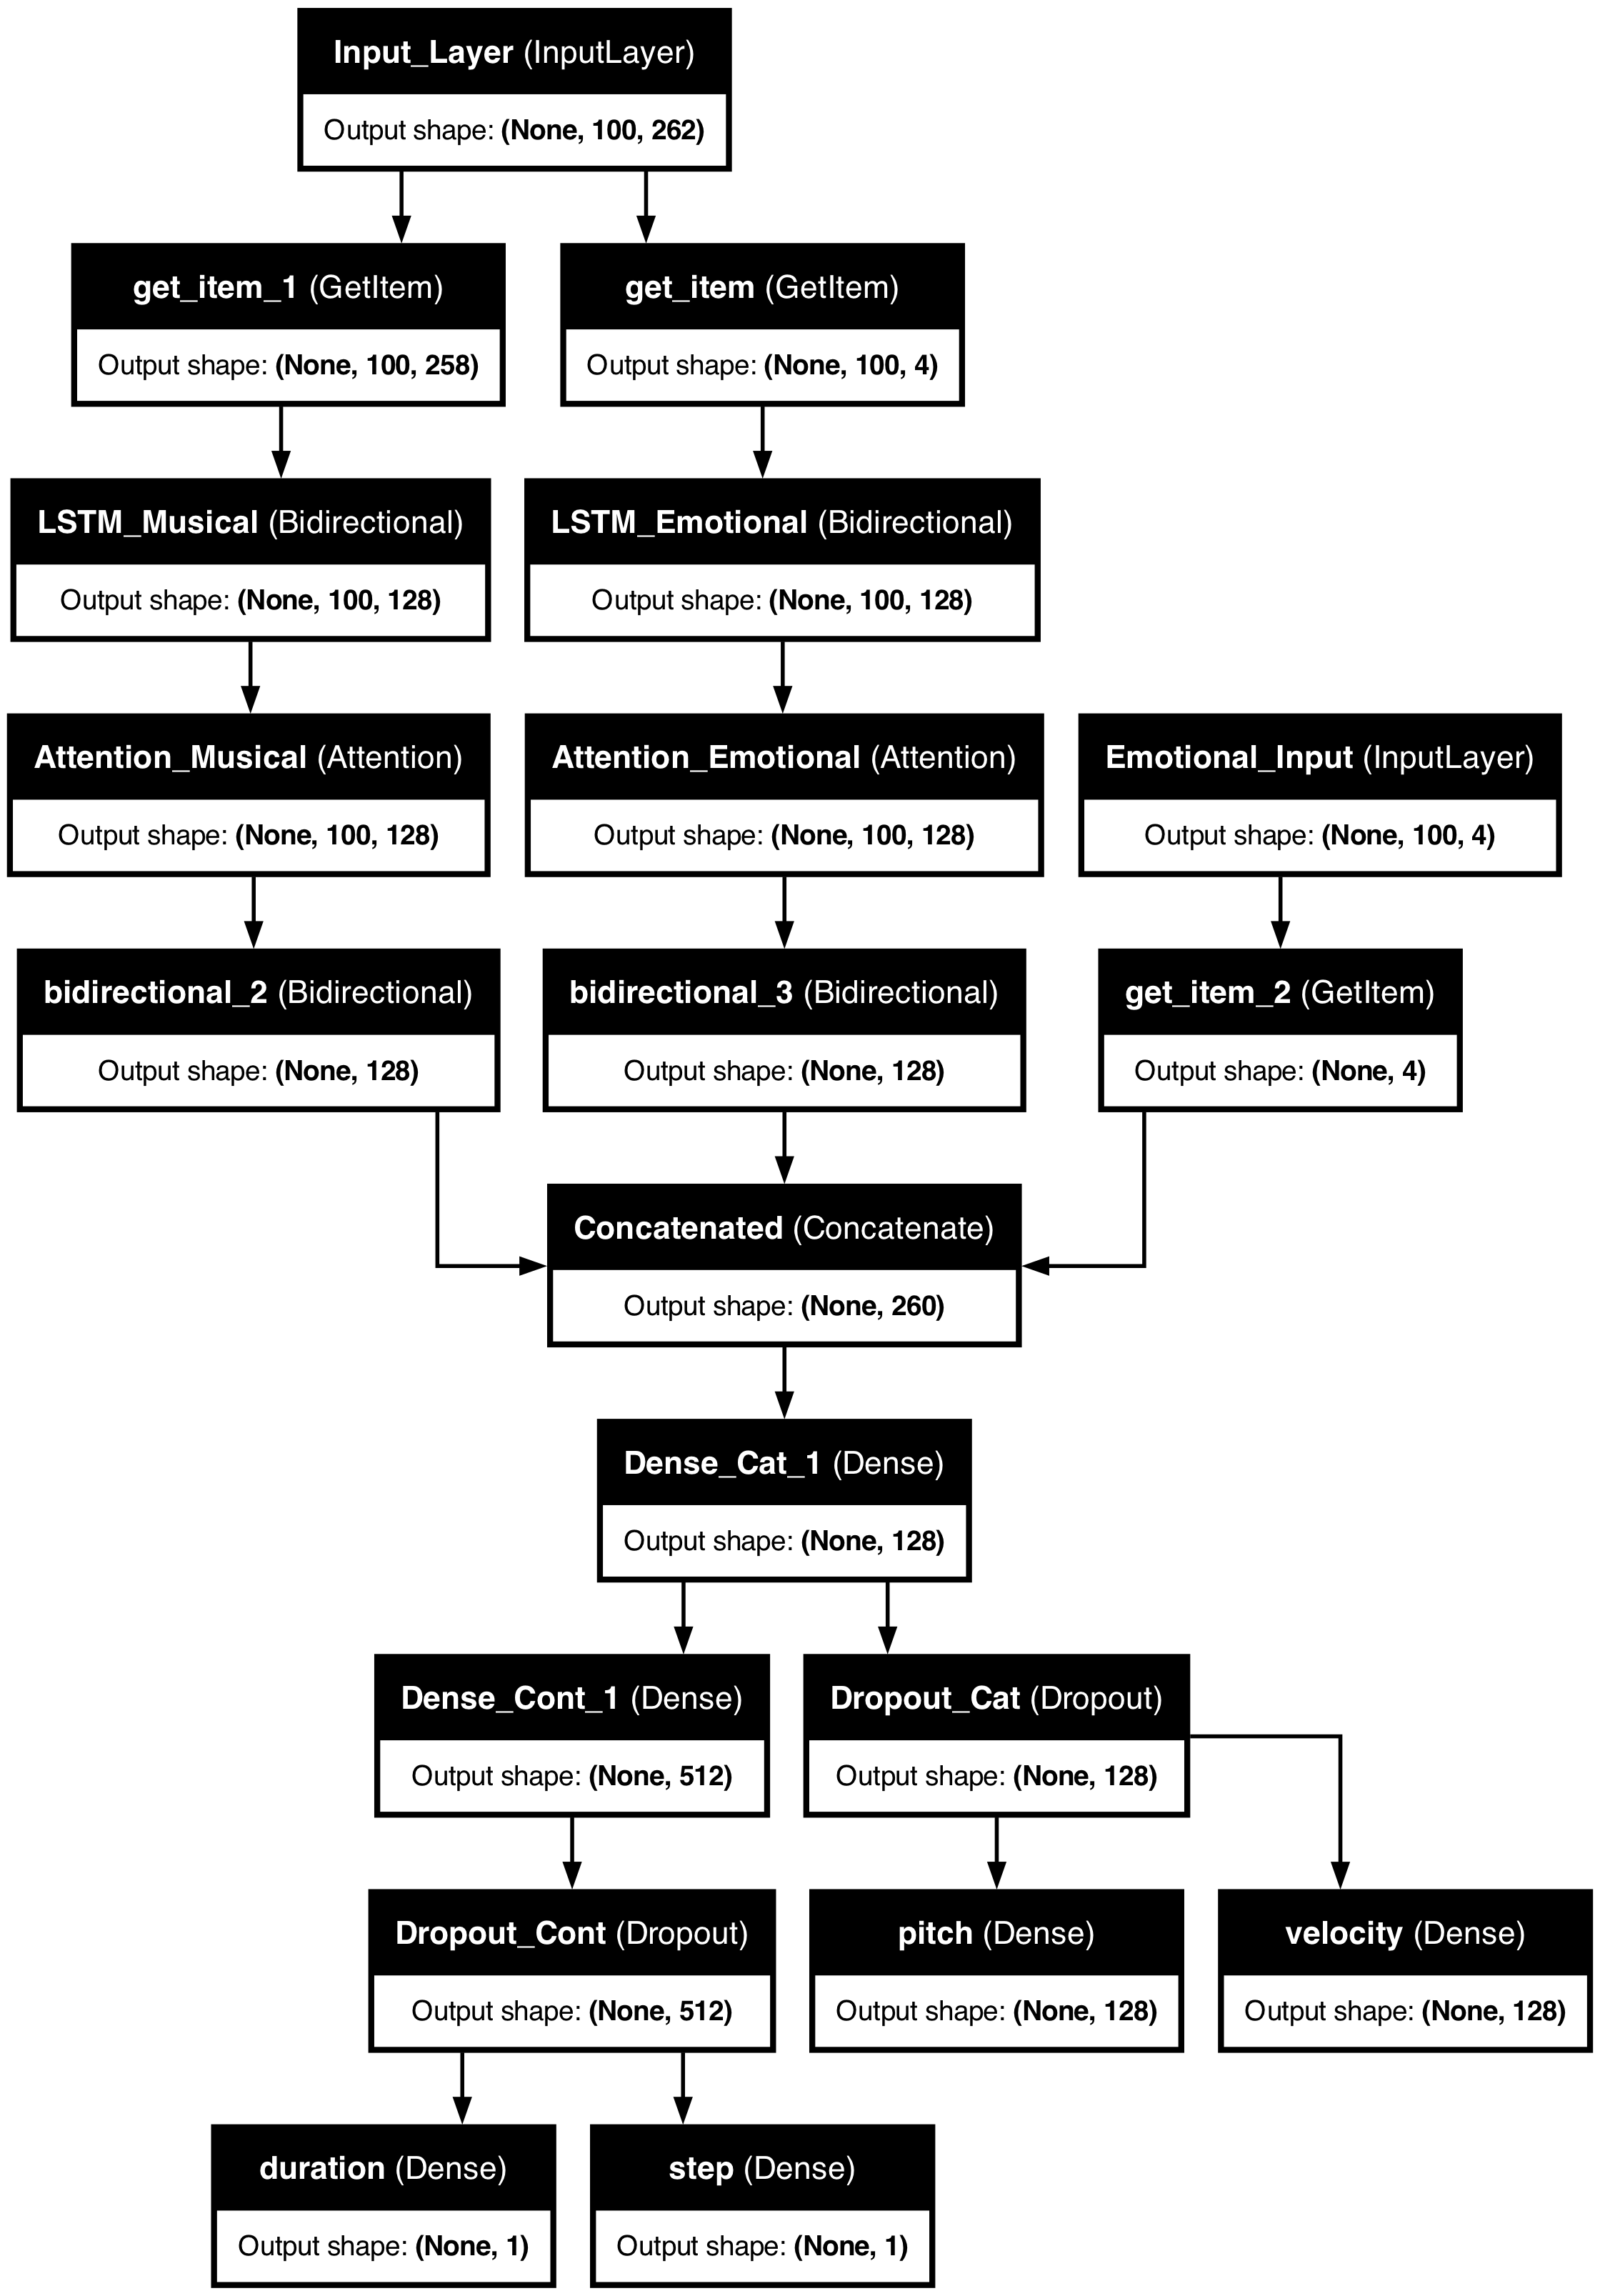

In [6]:
proposed_model = create_proposed_model((100, 262), 0.005)
plot_model(proposed_model, to_file='proposed.png', show_shapes=True, show_layer_names=True)

In [7]:
def create_proposed_model_2(shape, lr=0.005):
    inputs = tf.keras.Input(shape=shape, name='Input_Layer')

    pitches = inputs[:, :, :127]
    velocities = inputs[:, :, 128:256]
    step = inputs[:, :, 256:257]
    duration = inputs[:, :, 257:258]

    pitches = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), name='LSTM_Pitches_In' )(pitches)
    pitches = tf.keras.layers.Attention(name='Attention_Pitches')([pitches, pitches])
    pitches = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False),name='LSTM_Pitches_Out')(pitches)

    velocities = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), name='LSTM_Velocities_In' )(velocities)
    velocities = tf.keras.layers.Attention(name='Attention_Velocities')([velocities, velocities])
    velocities = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False), name='LSTM_Velocities_Out' )(velocities)

    step = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), name='LSTM_Step_in' )(step)
    step = tf.keras.layers.Attention(name='Attention_Step')([step, step])
    step = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False), name='LSTM_Step_Out' )(step)

    duration = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True), name='LSTM_Duration_In' )(duration)
    duration = tf.keras.layers.Attention(name='Attention_Duration')([duration, duration])
    duration = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False), name='LSTM_Duration_Out' )(duration)
    

   # Define an additional input for halfway through the architecture
    halfway_input = tf.keras.Input(shape=(100, 4), name='Emotional_Input')
    # Select only the last timestep's features
    halfway_features = halfway_input[:, -1, :]  # This now becomes a 2D tensor with shape (None, 4)

    # Merge the two LSTM outputs and the halfway input into one layer
    x = tf.keras.layers.concatenate([pitches, velocities, step, duration, halfway_features], name='Concatenated')

    # create a dense layer, plug in x, and emotinal_features # PLUG IN EMOTIONAL FEATURES
    x = tf.keras.layers.Dense(128, activation='relu', name='Dense_Cat_1')(x)

    # branch into x_cat
    x_cat = tf.keras.layers.Dropout(0.3, name='Dropout_Cat')(x)
    pitch = tf.keras.layers.Dense(128, activation='softmax', name='pitch')(x_cat)
    velocity = tf.keras.layers.Dense(128, activation='softmax', name='velocity')(x_cat)

    # branch into x_cont
    x_cont = tf.keras.layers.Dense(512, activation='relu', name='Dense_Cont_1')(x)
    x_cont = tf.keras.layers.Dropout(0.3, name='Dropout_Cont')(x_cont)
    step = tf.keras.layers.Dense(1, activation=None, name='step')(x_cont)  # Linear activation for continuous
    duration = tf.keras.layers.Dense(1, activation=None, name='duration')(x_cont)  # Linear activation for continuous

    model = tf.keras.Model(inputs=inputs, outputs={'pitch': pitch, 'velocity': velocity, 'step': step, 'duration': duration})
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss={
            'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            'velocity': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            'step': 'mse',   # Mean Squared Error for regression
            'duration': 'mse'
        }
    )

    return model

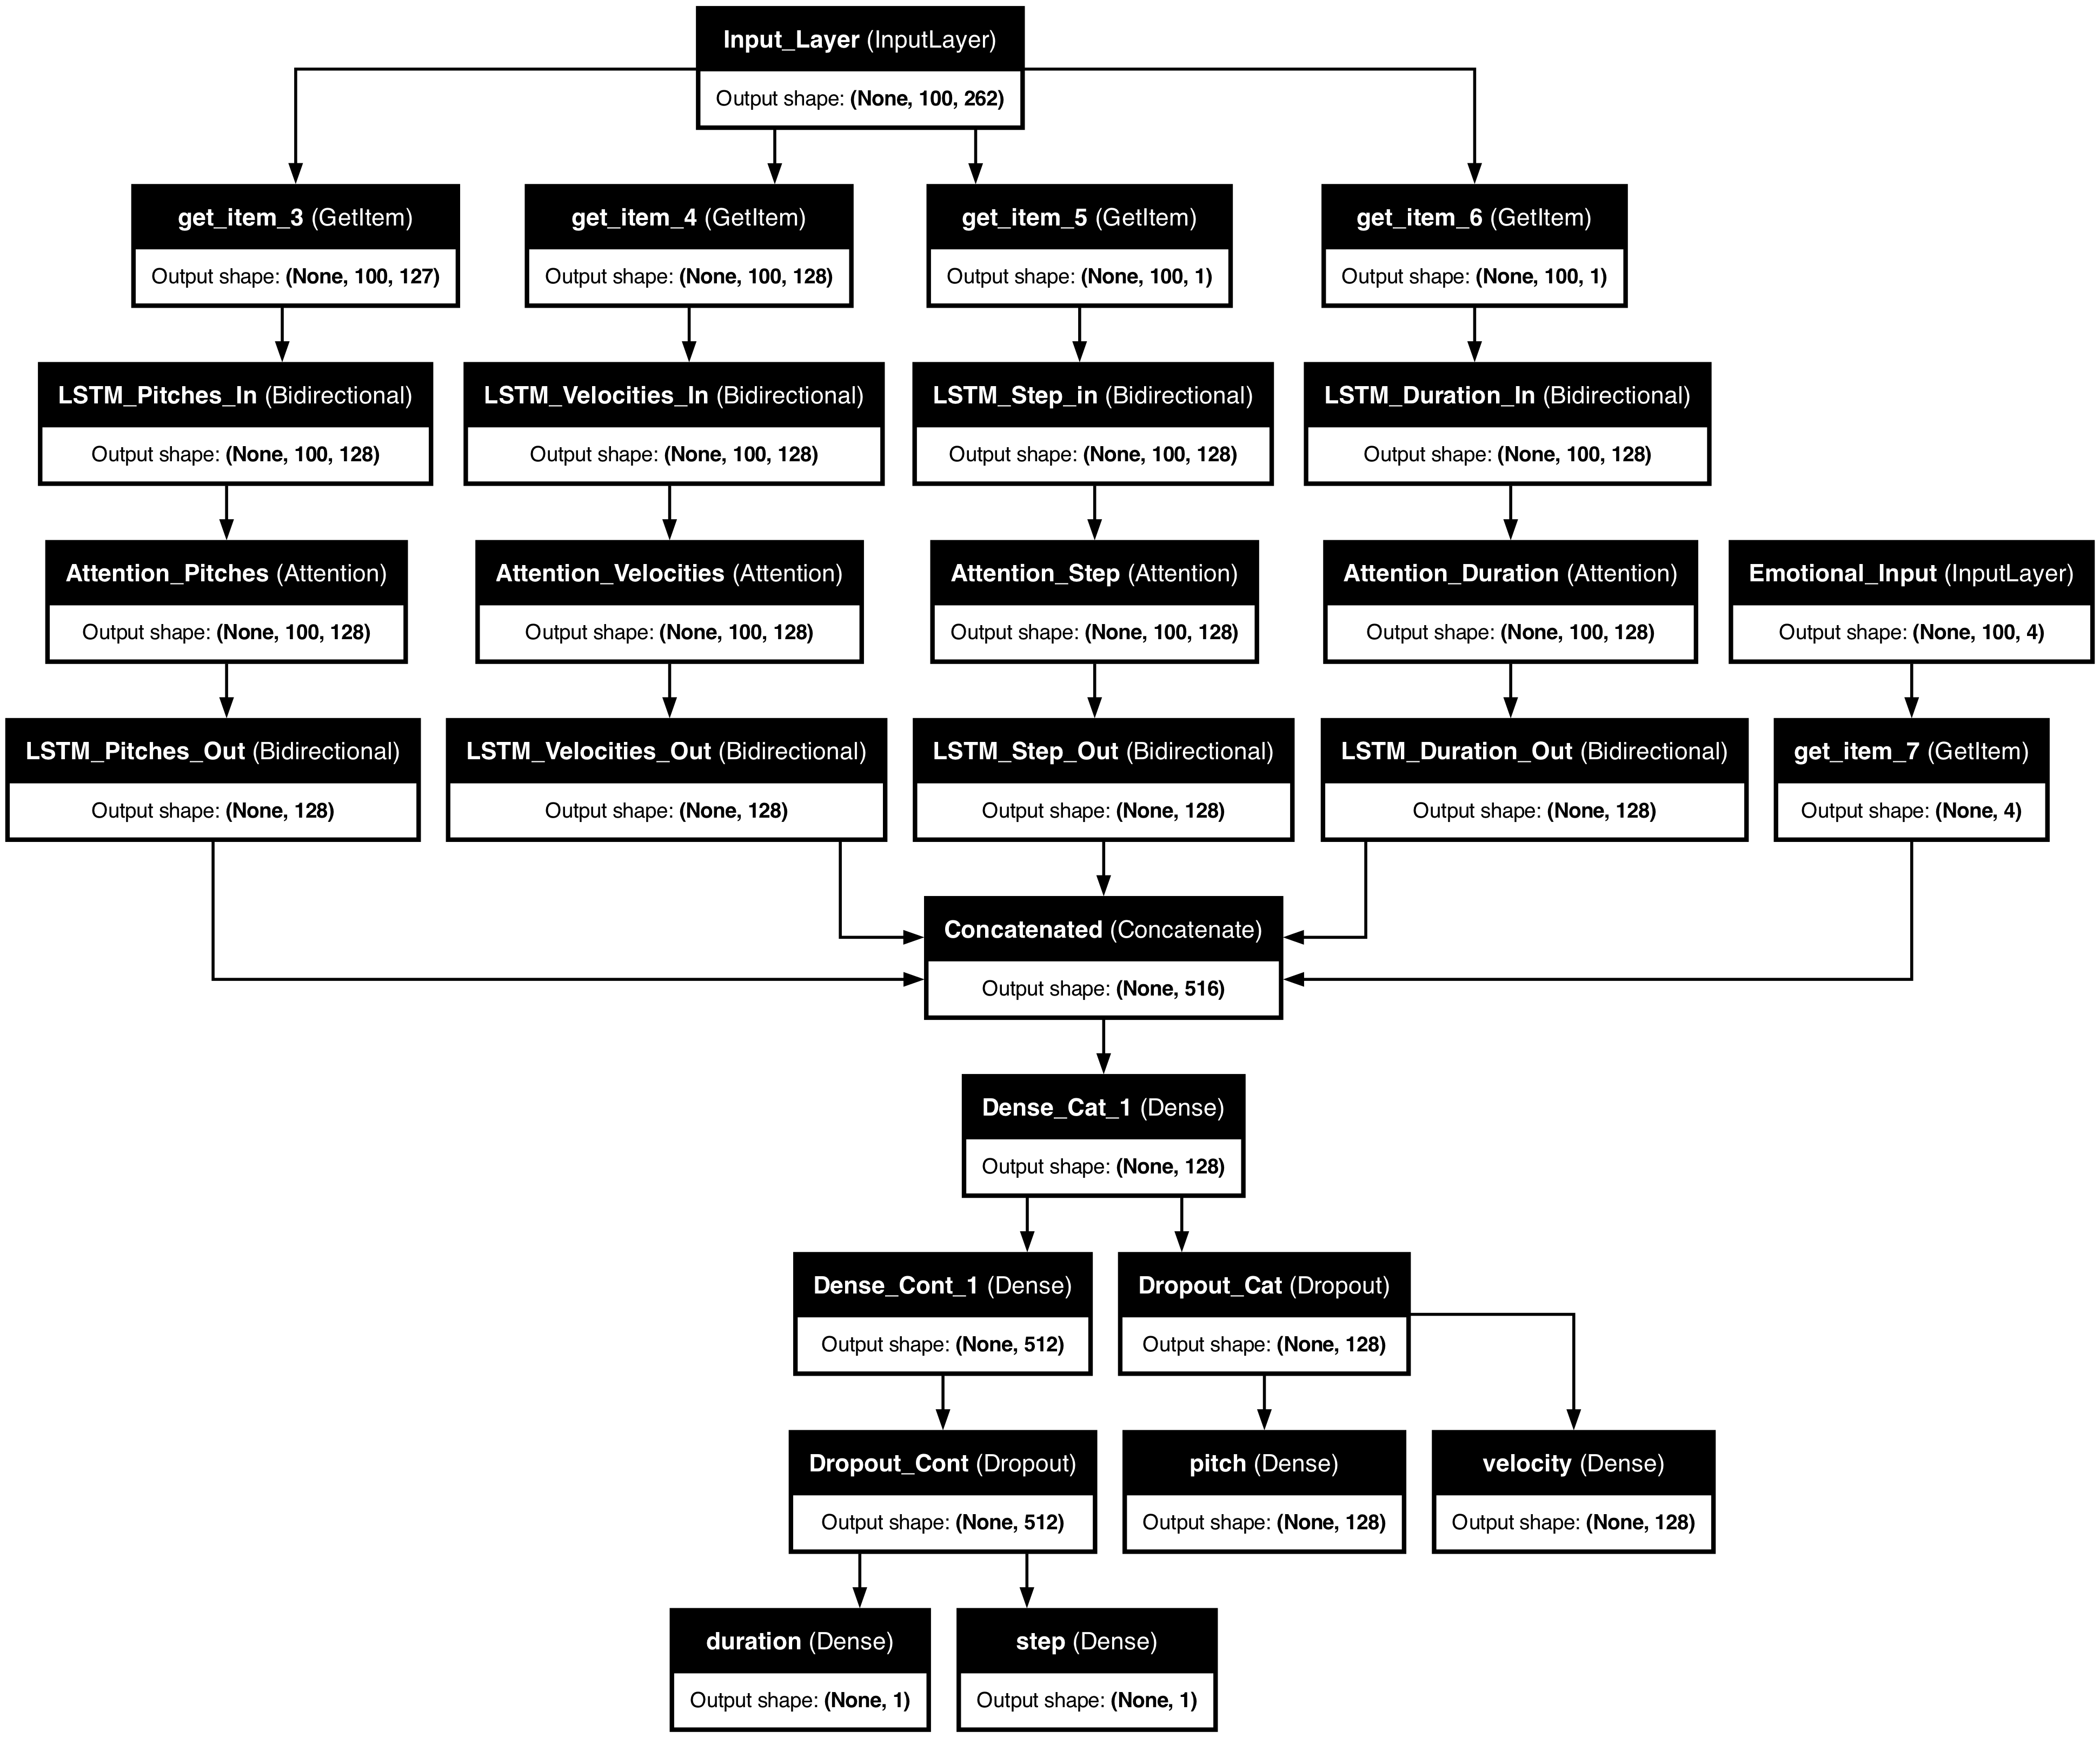

In [8]:
proposed_model = create_proposed_model_2((100, 262), 0.005)
plot_model(proposed_model, to_file='branched_proposed.png', show_shapes=True, show_layer_names=True)

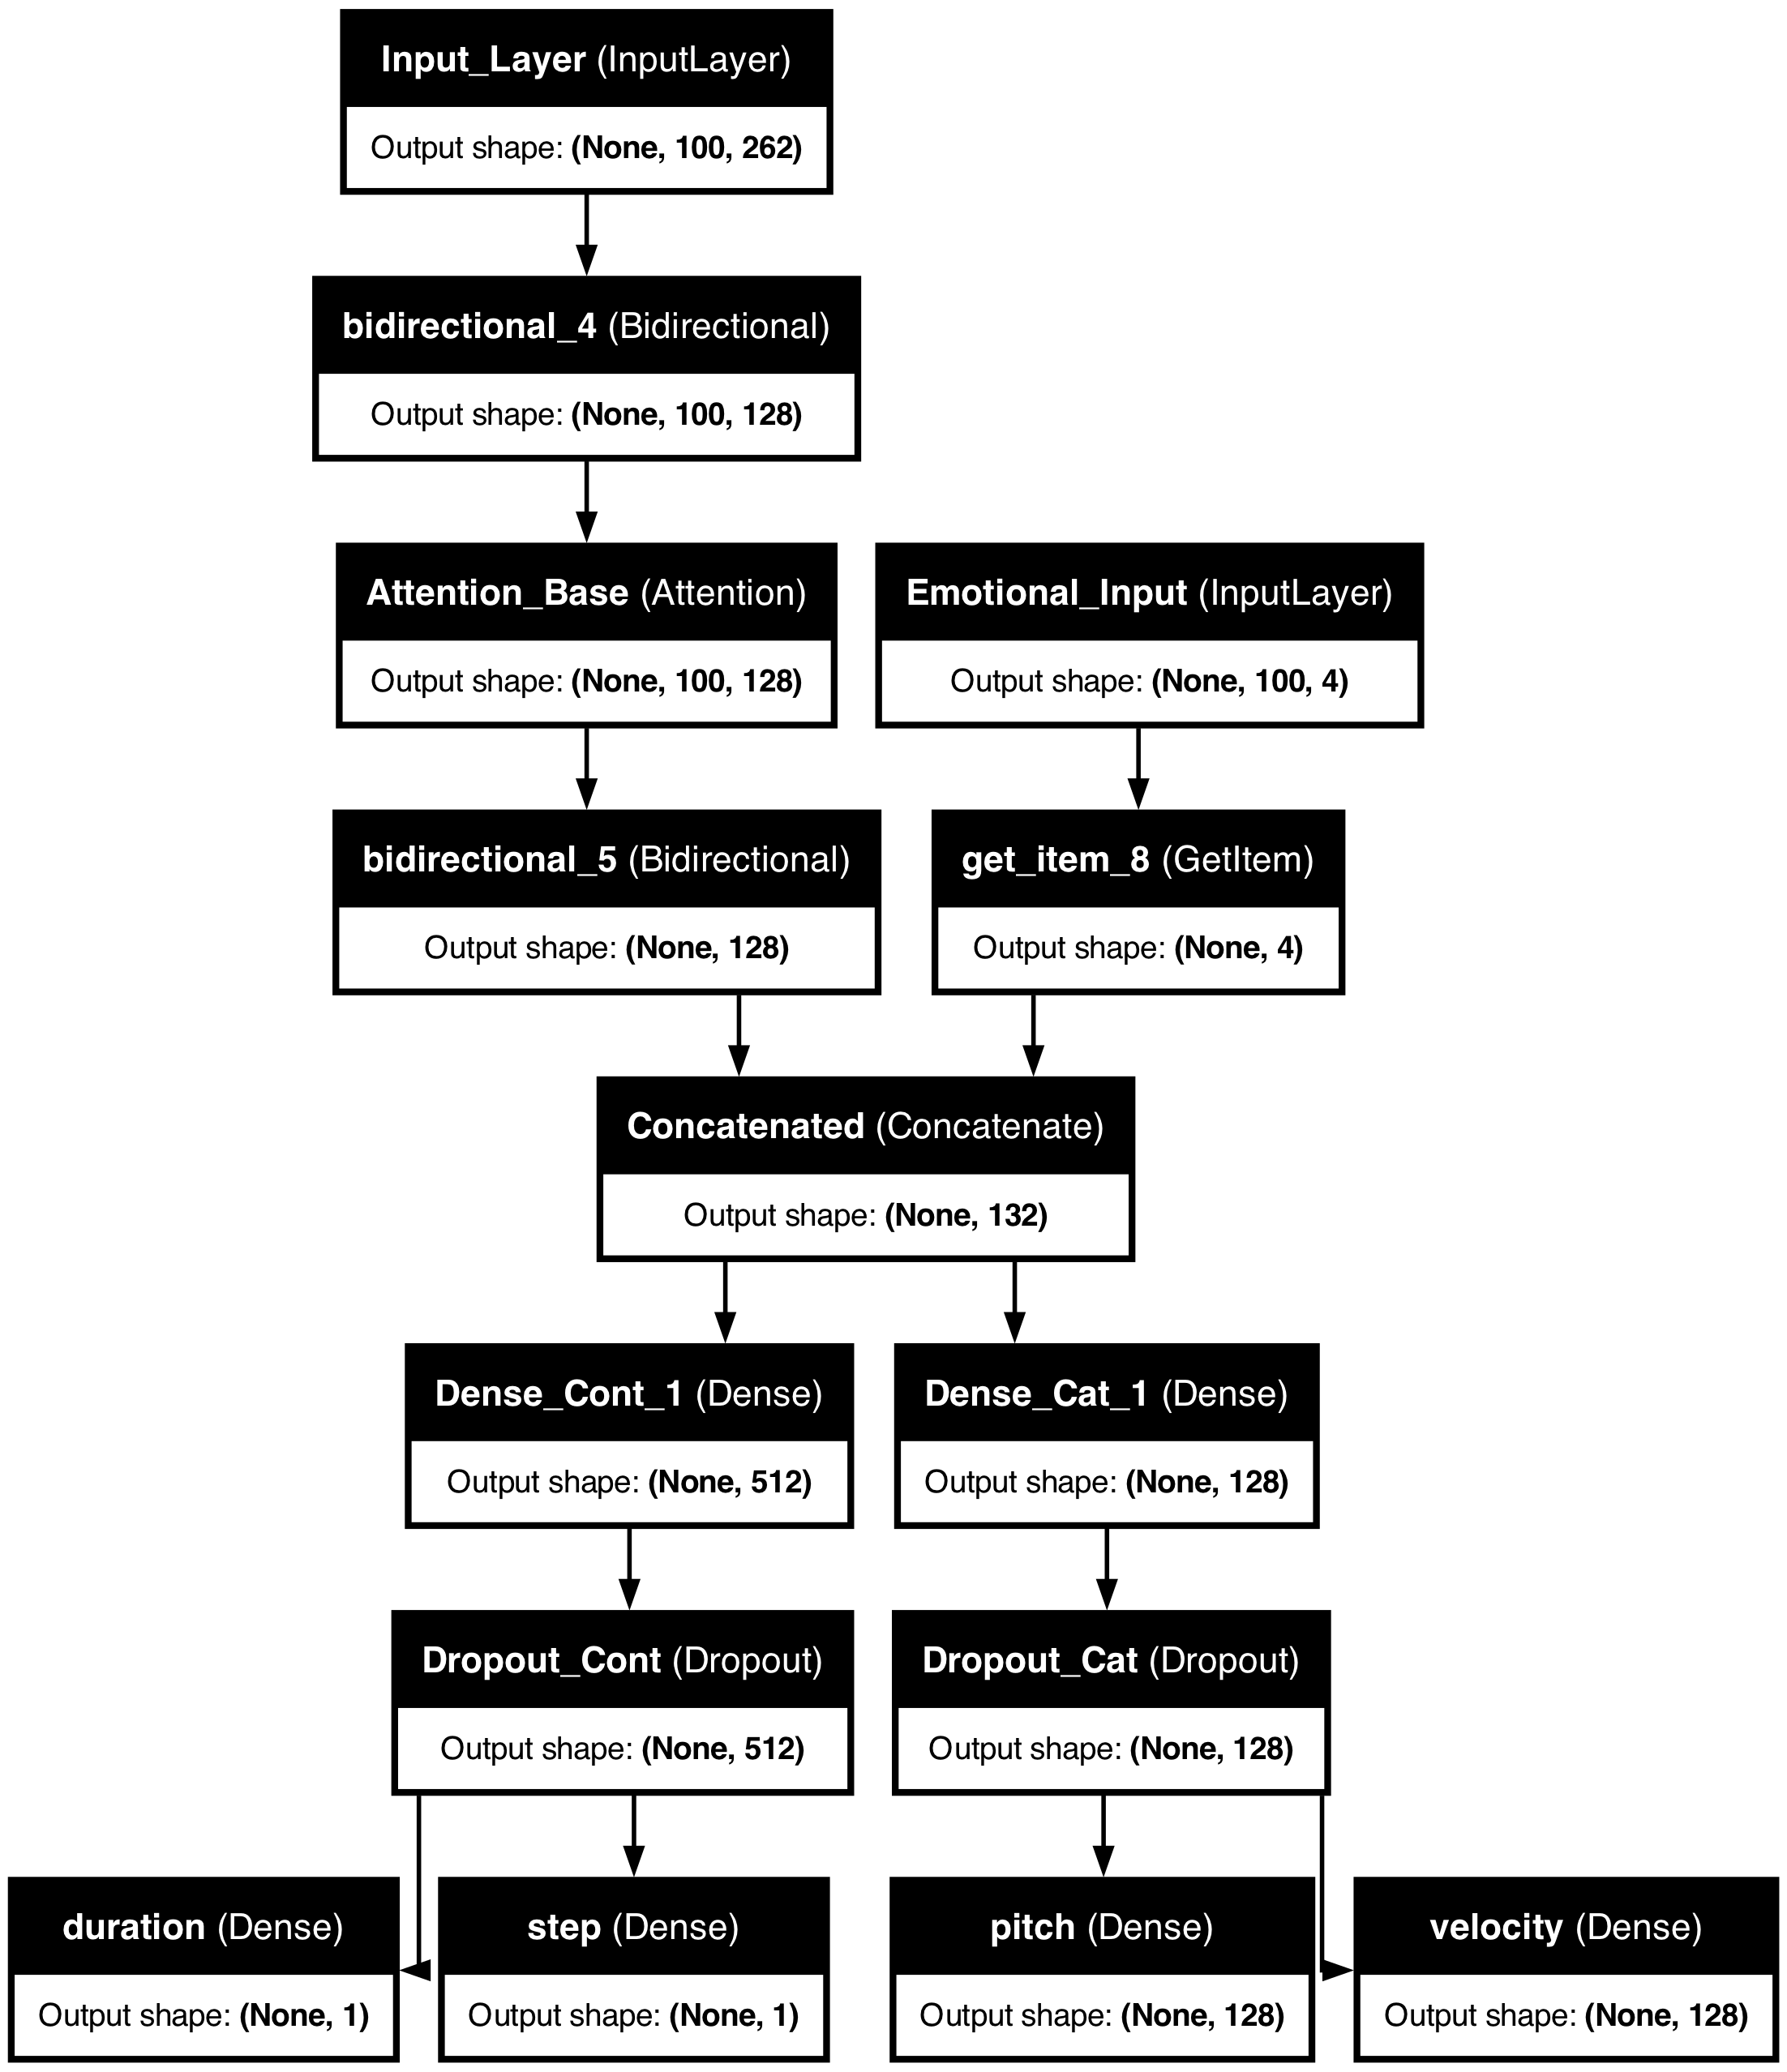

In [9]:
def create_novel_emotion_model(input_shape, learning_rate):
    inputs = tf.keras.Input(shape=input_shape, name='Input_Layer')

    # Base LSTM layers with attention
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, name='LSTM_Base'))(inputs)
    x = tf.keras.layers.Attention(name='Attention_Base')([x, x])

    # Final LSTM layer before branching
    final_lstm_layer = tf.keras.layers.LSTM(64, return_sequences=False, name='LSTM_Final')
    x = tf.keras.layers.Bidirectional(final_lstm_layer)(x)

    # Define an additional input for halfway through the architecture
    halfway_input = tf.keras.Input(shape=(100, 4), name='Emotional_Input')
    # Select only the last timestep's features
    halfway_features = halfway_input[:, -1, :]  # This now becomes a 2D tensor with shape (None, 4)

    # Merge the two LSTM outputs and the halfway input into one layer
    x = tf.keras.layers.concatenate([x, halfway_features], name='Concatenated')

    # Branch for categorical outputs
    x_cat = tf.keras.layers.Dense(128, activation='relu', name='Dense_Cat_1')(x)
    x_cat = tf.keras.layers.Dropout(0.3, name='Dropout_Cat')(x_cat)
    pitch = tf.keras.layers.Dense(128, activation='softmax', name='pitch')(x_cat)
    velocity = tf.keras.layers.Dense(128, activation='softmax', name='velocity')(x_cat)

    # Branch for continuous outputs
    x_cont = tf.keras.layers.Dense(512, activation='relu', name='Dense_Cont_1')(x)
    x_cont = tf.keras.layers.Dropout(0.3, name='Dropout_Cont')(x_cont)
    step = tf.keras.layers.Dense(1, activation=None, name='step')(x_cont)  # Linear activation for continuous
    duration = tf.keras.layers.Dense(1, activation=None, name='duration')(x_cont)  # Linear activation for continuous

    # Model setup
    model = tf.keras.Model(inputs=inputs, outputs={'pitch': pitch, 'velocity': velocity, 'step': step, 'duration': duration})
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss={
            'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            'velocity': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            'step': 'mse',   # Mean Squared Error for regression
            'duration': 'mse'
        }
    )

    return model

novel_emotion_model = create_novel_emotion_model((100, 262), 0.005)
plot_model(novel_emotion_model, to_file='novel_emotion.png', show_shapes=True, show_layer_names=True)